In [2]:
import pandas as pd
from copy import deepcopy
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
from scipy.stats import yeojohnson, rankdata
from sklearn.base import clone
import numpy as np
from sklearn import preprocessing
import warnings
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def add_transform_col(df, col, transform_name, transformed_name, group_col=None):
     # modified code from RS3 dev

    df = df.copy()
    min_group_size = df.groupby(group_col).size().min() if group_col else len(df)

    transforms = {
        'min-max-scaler': preprocessing.MinMaxScaler(),
        'robust-scaler': preprocessing.RobustScaler(),
        'quantile-uniform': preprocessing.QuantileTransformer(random_state=123, n_quantiles=min_group_size),
        'quantile-normal': preprocessing.QuantileTransformer(random_state=123, output_distribution='normal', n_quantiles=min_group_size),
        'z-score': preprocessing.StandardScaler()
    }

    if transform_name == 'yeo-johnson':
        if group_col is None:
            df[transformed_name] = yeojohnson(df[col])[0]
        else:
            df[transformed_name] = df.groupby(group_col)[col].transform(lambda x: yeojohnson(x)[0])
    elif transform_name == 'rank':
        if group_col is None:
            df[transformed_name] = rankdata(df[col])
        else:
            df[transformed_name] = df.groupby(group_col)[col].transform(lambda x: rankdata(x))
    elif transform_name == 'percentile':
        if group_col is None:
            df[transformed_name] = rankdata(df[col]) / len(df[col])
        else:
            df[transformed_name] = df.groupby(group_col)[col].transform(lambda x: rankdata(x) / len(x))
    elif transform_name in transforms:
        transform = transforms[transform_name]
        if group_col is None:
            df[transformed_name] = clone(transform).fit_transform(df[[col]])[:, 0]
        else:
            df[transformed_name] = df.groupby(group_col)[col].transform(lambda x: clone(transform).fit_transform(x.to_frame())[:, 0])
    else:
        raise ValueError(f"Unknown transform_name: {transform_name}")

    return df

# Function to compute correlations for each transformation and phenotype
def compute_correlations(df, columns_info, other_pheno_except_zscore, corr_type = 'pearson'):
    correlation_results = []
    processed_pairs = set()

    for transformation in columns_info['transformation'].unique():
        for phenotype in columns_info['phenotype'].unique():
            columns_subset = columns_info[
                (columns_info['transformation'] == transformation) &
                (columns_info['phenotype'] == phenotype)
            ]['column']
            if not columns_subset.empty:
                if phenotype == 'ScaledZscore':
                    # Only consider correlations within the same phenotype of ScaledZscore
                    corr = df[columns_subset].corr(corr_type)
                else:
                    # Consider correlations across different phenotypes ScaledLFC ScaledRho
                    other_columns_subset = columns_info[
                        (columns_info['transformation'] == transformation) &
                        (columns_info['phenotype'].isin(other_pheno_except_zscore))
                    ]['column']
                    corr = df[other_columns_subset].corr(corr_type).loc[other_columns_subset, other_columns_subset]
                    
                    
                for col1 in corr.columns:
                    for col2 in corr.index:
                        if col1 != col2 and col1.split('_')[0] != col2.split('_')[0] and (col2, col1) not in processed_pairs:
                            processed_pairs.add((col1, col2))
                            correlation_results.append({
                                'Column1': col1,
                                'Column2': col2,
                                'Correlation': corr.loc[col2, col1]
                            })
    
    correlation_df = pd.DataFrame(correlation_results)
    return correlation_df.drop_duplicates().sort_values('Correlation',ascending = True)
# Function to split and extract the necessary parts
def extract_parts(row):
    col1_parts = row['Column1'].split('_')
    col2_parts = row['Column2'].split('_')
    dataset_comparison = f"{col1_parts[0]} vs {col2_parts[0]}"
    phenotype = f"{col1_parts[1]} vs {col2_parts[1]}"
    transformation = col1_parts[2]
    return pd.Series([dataset_comparison, phenotype, transformation, row['Correlation']], index=['DatasetComparison', 'Phenotype', 'Transformation', 'Correlation'])


def yhat(df, org_x, org_y):
    x = df[org_x]
    y = df[org_y]
    
    # Adding a constant for the intercept term
    x = sm.add_constant(x)
    
    # Fit the model
    model = sm.OLS(y, x).fit()
    
    # Extracting parameters
    intercept, slope = model.params
    p_value = model.pvalues[1]  # p-values[1] corresponds to the slope
    print(f'pVal of slope: {p_value}')
    print(f'intercept: {intercept} and slope: {slope}')
    yhat_name = org_x +'_hat'
    df[yhat_name] = df[org_x]*slope + intercept

    return df

def plot_byGene_andEntire(df, x, y, plot = True,corr_type = 'pearson'):
    graphName = x + ' vs ' + y
    plt.subplots(figsize=(4,4))
    gpplot.point_densityplot(data=df, 
                             x=x, y=y)
    gpplot.add_correlation(data=df, 
                           x=x, y=y, 
                           method=corr_type)
    sns.despine()
    #if plot:
        #plt.savefig(graph_pathout + graphName + ".pdf", dpi=300, bbox_inches='tight')
    # else:
    #     pass
    

In [10]:
graph_pathout = '../Figure/Figure 3/Individual Figures/'

In [5]:
cleanedAllData_path = '../Data/CleanedExternalData/'
NewDatasetCombine = pd.read_csv(cleanedAllData_path + 'DatasetCombineCleaned_v3.csv', low_memory=False)
NewDatasetCombine['sgRNA Context Sequence'] = NewDatasetCombine['sgRNA Context Sequence'].apply(lambda x: x.upper())

NewDatasetCombineInHouse = NewDatasetCombine[(NewDatasetCombine.DataSet == 'InHouse')].copy()#.groupby('Domain')
NewDatasetCombineInHouseAvgDomain = NewDatasetCombineInHouse.groupby([ 'Target Gene Symbol', 'chromosome', 'sgRNA Sequence',
       'sgRNA Context Sequence', 'sgRNA \'Cut\' Position', 'Strand of Target',
       'TSS Position', 'sgRNA \'Cut\' Site TSS Offset','Domain'])['z_scored_avg_lfc'].mean().reset_index()
# only selecting the InHouse dataset because I want InHouse and Gilbert to be on the same scale
# I used Kox1 because Gilbert also use Kox1. 
NewDatasetCombineInHouseKox1 = NewDatasetCombineInHouseAvgDomain[(NewDatasetCombineInHouseAvgDomain.Domain == 'Kox1') ]
NewDatasetCombineInHouseKox1 = NewDatasetCombineInHouseKox1.rename(columns = {'z_scored_avg_lfc': 'AveragedZscoreKox1InHouse'})
#Also added Zim3 because i want to to save it for later 
NewDatasetCombineInHouseZim3 = NewDatasetCombineInHouseAvgDomain[(NewDatasetCombineInHouseAvgDomain.Domain == 'Zim3') ]
NewDatasetCombineInHouseZim3 = NewDatasetCombineInHouseZim3.rename(columns = {'z_scored_avg_lfc': 'AveragedZscoreZim3InHouse'})

# import inhouse data with LFC 
inhouseLFC_path = "../Data/PrimaryLibrary/processed_z_score/"
inhouseLFC = pd.read_csv(inhouseLFC_path + "inHouseDatasetsCombined.csv")
inhouseLFC['avgLFC_A549Kox1'] = inhouseLFC[['avg_lfc_A549_Kox1' ,'avg_lfc_HCT116_Kox1']].mean(axis=1)
inhouseLFC = inhouseLFC[['Target Gene Symbol', 'sgRNA Context Sequence', 'avgLFC_A549Kox1','Category']]

# combine to have LFC
NewDatasetCombineInHouseKox1 = pd.merge(NewDatasetCombineInHouseKox1,inhouseLFC )
NewDatasetCombineInHouseKox1_keepcol = ['Target Gene Symbol','sgRNA Context Sequence', 'AveragedZscoreKox1InHouse', 'avgLFC_A549Kox1','Category']
NewDatasetCombineInHouseKox1 = NewDatasetCombineInHouseKox1[NewDatasetCombineInHouseKox1_keepcol]
NewDatasetCombineInHouseKox1 = NewDatasetCombineInHouseKox1[NewDatasetCombineInHouseKox1.Category == 'Essential']

NewDatasetCombineInHouseZim3 = pd.merge(NewDatasetCombineInHouseZim3,inhouseLFC )
NewDatasetCombineInHouseZim3 = NewDatasetCombineInHouseZim3[NewDatasetCombineInHouseZim3.Category == 'Essential']


In [6]:
#  Gilbert dataset
GilbertRicinCleanData = NewDatasetCombine[NewDatasetCombine.DataSet == 'Gilbert']
GilbertRicinCleanData_keepcol = ['Target Gene Symbol','sgRNA Context Sequence', 'rhoSignChangedAndAvged','zscoreRelativeNC_signed', 'Avg_LFC_signed']
GilbertRicinCleanData = GilbertRicinCleanData[GilbertRicinCleanData_keepcol]

In [7]:
# List of transformations
transforms = ['yeo-johnson', 'quantile-uniform', 'robust-scaler', 'min-max-scaler', 
              'quantile-normal','z-score','rank', 'percentile']
# # Apply transformation to rhoSignChangedAndAvged, zscoreRelativeNC_signed, Avg_LFC_signed

for transform in transforms:
    NewDatasetCombineInHouseKox1 = add_transform_col(NewDatasetCombineInHouseKox1, 'avgLFC_A549Kox1', transform, f'InHouse_ScaledLFC_{transform}', group_col='Target Gene Symbol')
    NewDatasetCombineInHouseKox1 = add_transform_col(NewDatasetCombineInHouseKox1, 'AveragedZscoreKox1InHouse', transform, f'InHouse_ScaledZscore_{transform}', group_col='Target Gene Symbol')
    NewDatasetCombineInHouseZim3 = add_transform_col(NewDatasetCombineInHouseZim3, 'AveragedZscoreZim3InHouse', transform, f'InHouse_ScaledZscore_{transform}', group_col='Target Gene Symbol')
    GilbertRicinCleanData = add_transform_col(GilbertRicinCleanData, 'Avg_LFC_signed', transform, f'Gilbert_ScaledLFC_{transform}', group_col='Target Gene Symbol')
    GilbertRicinCleanData = add_transform_col(GilbertRicinCleanData, 'zscoreRelativeNC_signed', transform, f'Gilbert_ScaledZscore_{transform}', group_col='Target Gene Symbol')
    GilbertRicinCleanData = add_transform_col(GilbertRicinCleanData, 'rhoSignChangedAndAvged', transform, f'Gilbert_ScaledRho_{transform}', group_col='Target Gene Symbol')

# merge inhouse and gilbert together using common context seq and gene
samegRNAInHouseGilbert = pd.merge(
    GilbertRicinCleanData,
   NewDatasetCombineInHouseKox1, 
                               on = ['Target Gene Symbol', 'sgRNA Context Sequence'])

In [8]:
# only keeping the transformed phenotype
remove_col = NewDatasetCombineInHouseKox1_keepcol + GilbertRicinCleanData_keepcol
samegRNAInHouseGilbert_phenotype = samegRNAInHouseGilbert.drop(remove_col, axis=1)
# Extract dataset, phenotype, and transformation information
columns_info = samegRNAInHouseGilbert_phenotype.columns.str.extract(r'(?P<dataset>[^_]+)_(?P<phenotype>[^_]+)_(?P<transformation>[^_]+)')
columns_info['column'] = samegRNAInHouseGilbert_phenotype.columns
# Compute correlations
correlations = compute_correlations(samegRNAInHouseGilbert, columns_info, 
                                    ['ScaledLFC', 'ScaledRho'],'pearson')
correlations

,Column1,Column2,Correlation
11,Gilbert_ScaledRho_robust-scaler,InHouse_ScaledLFC_robust-scaler,-0.487727
16,Gilbert_ScaledRho_min-max-scaler,InHouse_ScaledLFC_min-max-scaler,-0.462027
26,Gilbert_ScaledRho_z-score,InHouse_ScaledLFC_z-score,-0.438172
36,Gilbert_ScaledRho_percentile,InHouse_ScaledLFC_percentile,-0.437433
6,Gilbert_ScaledRho_quantile-uniform,InHouse_ScaledLFC_quantile-uniform,-0.436720
12,Gilbert_ScaledZscore_robust-scaler,InHouse_ScaledZscore_robust-scaler,-0.413956
10,Gilbert_ScaledLFC_robust-scaler,InHouse_ScaledLFC_robust-scaler,-0.411863
21,Gilbert_ScaledRho_quantile-normal,InHouse_ScaledLFC_quantile-normal,-0.398984
15,Gilbert_ScaledLFC_min-max-scaler,InHouse_ScaledLFC_min-max-scaler,-0.363231
17,Gilbert_ScaledZscore_min-max-scaler,InHouse_ScaledZscore_min-max-scaler,-0.363004


In [9]:
# Apply the function to each row
correlations_new = correlations.apply(extract_parts, axis=1)
correlations_new.to_csv('../Data/CleanedScaledData/Correlation/correlationsGilbertInHouse.csv',
                       index = False)

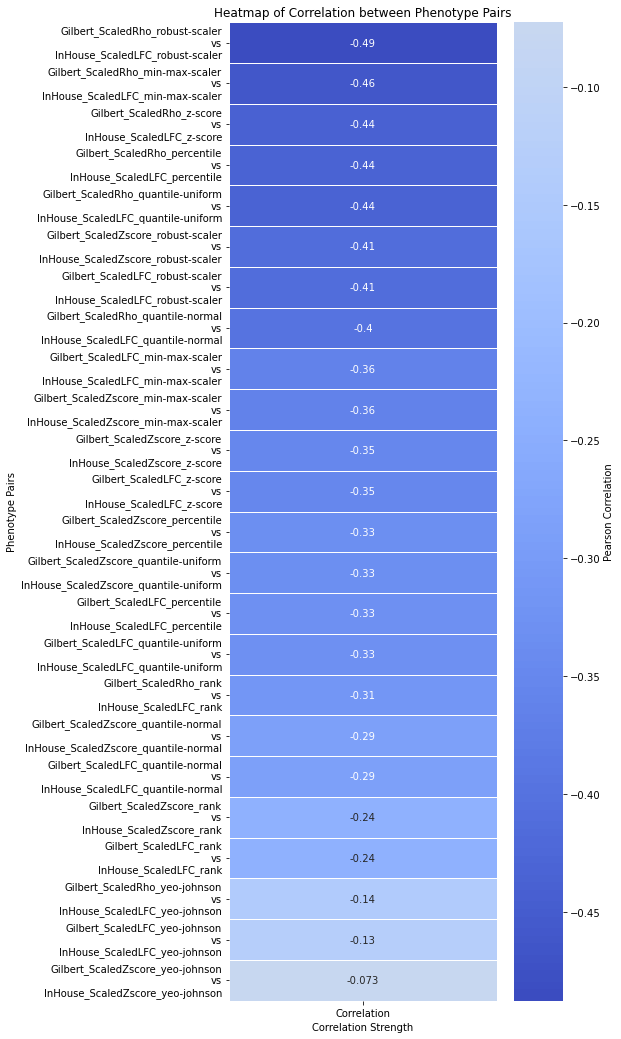

In [11]:
# Combine col1 and col2 into a single column with newlines
correlations['col_pair'] = correlations['Column1'] + '\nvs\n' + correlations['Column2']

# Create a pivot table with the combined pairs as the index and correlation values as the single column
pivot_table = correlations.pivot_table(index='col_pair', values='Correlation')
pivot_table = pivot_table.reindex(pivot_table['Correlation'].abs().sort_values(ascending=False).index)

# Plot the heatmap
plt.figure(figsize=(6, 18))  
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Pearson Correlation'}, linewidths=0.5)
plt.title('Heatmap of Correlation between Phenotype Pairs')
plt.xlabel('Correlation Strength')
plt.ylabel('Phenotype Pairs')
plt.savefig(graph_pathout + "GilbertScalingCorr.pdf", dpi=300, bbox_inches='tight')
plt.show()


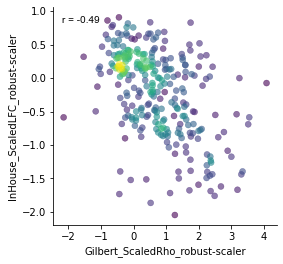

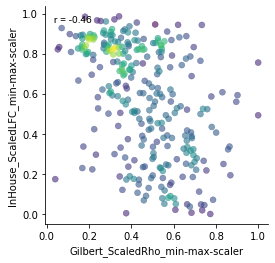

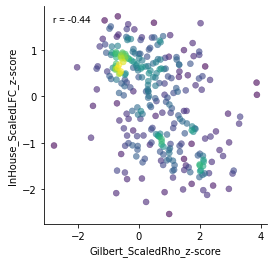

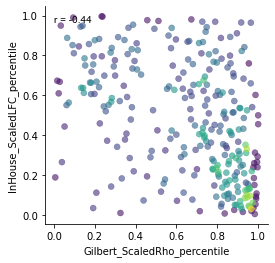

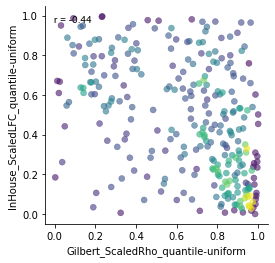

In [12]:
correlationsHigh = correlations.head(5)
for index, row in correlationsHigh.iterrows():
    plot_byGene_andEntire(samegRNAInHouseGilbert, row['Column1'], row['Column2'])

pVal of slope: 2.2335861896024564e-18
intercept: -0.001423404471689458 and slope: -0.29920674723376095
pVal of slope: 2.0055287878236425e-16
intercept: 0.8893095872177814 and slope: -0.6938869556530471
pVal of slope: 9.418325191457893e-15
intercept: 0.12067641345457757 and slope: -0.39018316522064744
pVal of slope: 1.0560979200502801e-14
intercept: 0.7624718766061678 and slope: -0.44229307584638344
pVal of slope: 1.1790855822471916e-14
intercept: 0.7596223294068821 and slope: -0.44211912435655787


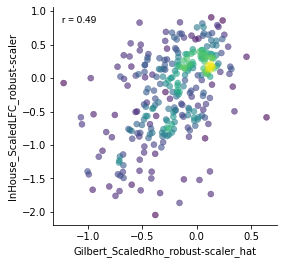

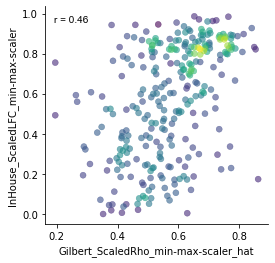

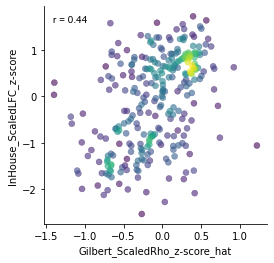

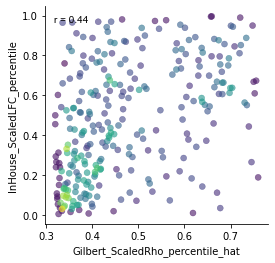

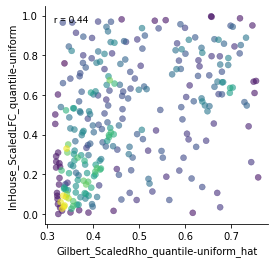

In [13]:
for index, row in correlationsHigh.iterrows():
    x = row['Column1']
    y = row['Column2']
    samegRNAInHouseGilbert = yhat(samegRNAInHouseGilbert, x,y)
    plot_byGene_andEntire(samegRNAInHouseGilbert, f'{x}_hat', y, False)
    

In [14]:
inHouseZim3ScaledData = NewDatasetCombineInHouseZim3[['Target Gene Symbol', 'sgRNA Context Sequence','InHouse_ScaledZscore_z-score']].copy()
inHouseZim3ScaledData['Domain'] = 'Zim3'
inHouseZim3ScaledData['DataSet'] = 'InHouse'
inHouseZim3ScaledData = inHouseZim3ScaledData.rename(columns = {'InHouse_ScaledZscore_z-score': 'doubleZscore'} )


In [15]:
inHouseZim3ScaledData.head(3)

,Target Gene Symbol,sgRNA Context Sequence,doubleZscore,Domain,DataSet
0,AATF,CTTCAAAACTAAGTTGGAGACTGATGGAAG,-0.073905,Zim3,InHouse
1,AATF,CTCGAAACTTGGTGCTCGGCTGGATGGGCG,0.313604,Zim3,InHouse
2,AATF,AAGCAAAGAAAACTCCCCAAAGAATGGGAC,0.529159,Zim3,InHouse


In [16]:
GilbertRicinScaledData = GilbertRicinCleanData[['Target Gene Symbol', 'sgRNA Context Sequence','Gilbert_ScaledZscore_z-score']].copy()
GilbertRicinScaledData['Domain'] = 'Kox1'
GilbertRicinScaledData['DataSet'] = 'Gilbert'
GilbertRicinScaledData = GilbertRicinScaledData.rename(columns = {'Gilbert_ScaledZscore_z-score': 'doubleZscore'} )


In [17]:
GilbertRicinScaledData.head(3)

,Target Gene Symbol,sgRNA Context Sequence,doubleZscore,Domain,DataSet
68575,ARF1,AAGGTGTGGAGCTACTTTGCTCTAGGGCCT,0.622412,Kox1,Gilbert
68576,ARF1,GAAGGTGTGGAGCTACTTTGCTCTAGGGCC,0.773034,Kox1,Gilbert
68577,ARF1,ACGGCTTTGAAGAGACATGGCTGAAGGTGT,1.549232,Kox1,Gilbert


In [18]:
dataOut = '../Data/CleanedScaledData/'
GilbertRicinScaledData.to_csv(dataOut+'GilbertRicinScaledData.csv', index = False)

In [19]:
inHouseZim3ScaledData.to_csv(dataOut+'inHouseZim3ScaledData.csv', index = False)